# Predicting prices for Airbnb rentals

<p style="text-align: justify">Platforms to connect landlords and tentants for temporary housing have become a cheap and good alternative to traditional hotel bookings in the tourism industry.</p>
<p style="text-align: justify">Airbnb's business model relies mainly on a fee charged from the total rental price, so it's in their best interest to optimize the prices in order to maximize their revenue. From the point of view of guests, it is benefitial to them to have fair prices that reflect the market and the value of properties. Likewise, hosts don't want to undercharge for the property nor overcharge, because it can reduce the demand.</p>
<p style="text-align: justify">Thus, the question I'm trying to answer is: <b>Can we predict rental prices from features related to the property ?</b></p>

## Loading the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/train.csv")

In [3]:
df.shape

(74111, 29)

In [4]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

Here, we have a dataset of 74,111 rows and 28 features related to the property, such as location, reviews and rooms. The target variable is the log of the price.

The first thing to do is to separate the target variable from the features. The target column is *log_price*, while all the other columns will be part of the feature dataset, except for the id, which I'll drop now as it is not relevant to the problem (it is a unique number for each row).

In [5]:
X_raw = df.iloc[:,2:]
y = df["log_price"]

## Cleaning the data

In [44]:
from sklearn.model_selection import train_test_split
import missingno as msno
from datetime import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

Before we start fitting models into the data, it is useful to explore the dataset to detect anomalies, handle missing values and preprocess some features.

Let's now see a sample of the first 5 rows of the feature set and a brief description of the main statistics:

In [8]:
pd.set_option("display.max_columns", None)
X_raw.head()

,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


We can see some missing values in the data. Let's dive deep into this problem.

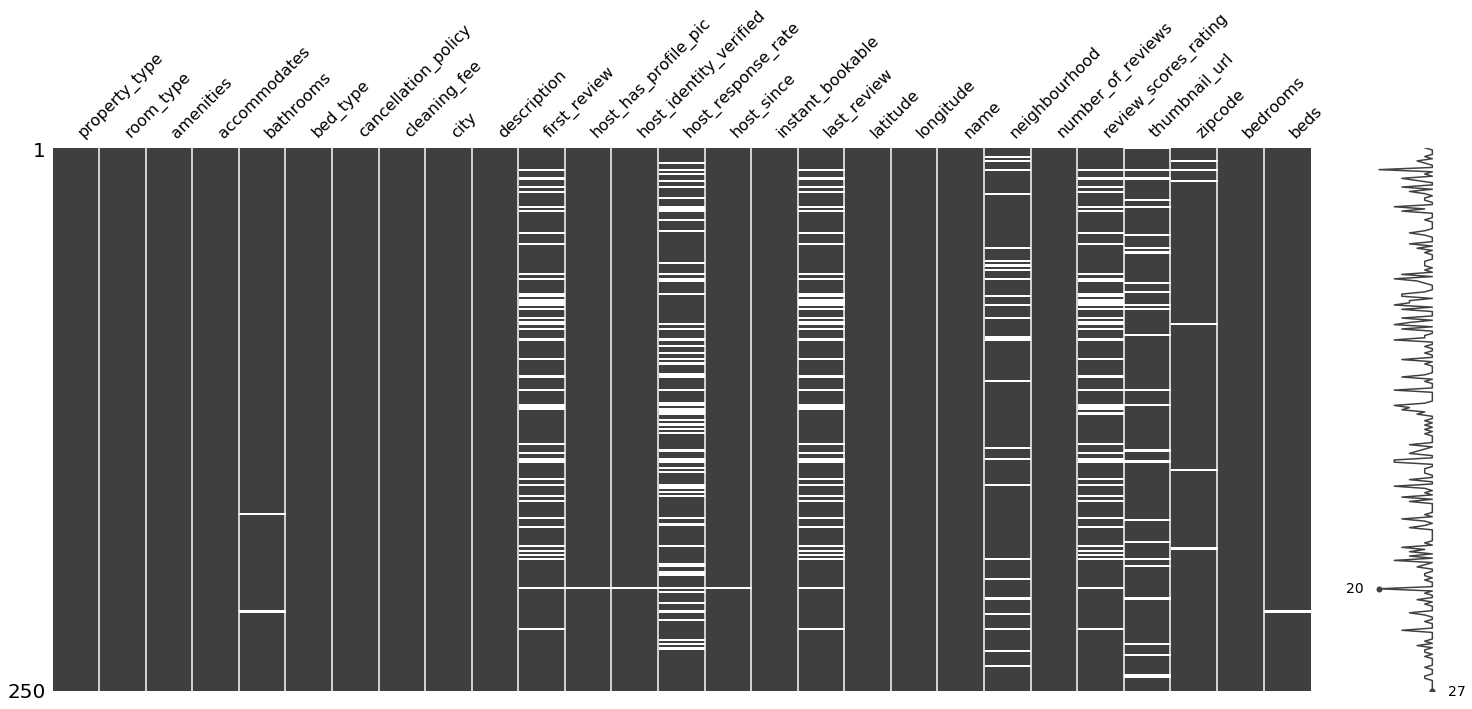

In [9]:
msno.matrix(X_raw.sample(250))

<p style="text-align: justify">Some columns have a lot of missing values, so it is not reasonable to remove all those rows from the dataset. Also, by dropping those columns we would lose valuable information to the models. Therefore, the approach I'm going to use is to replace the missing values by the string 'NA' if the variable is categorical, or by 0 if the variable is numerical. Besides replacing by 0 in the numerical case, I'll add boolean features that indicate if the row had a missing value or not. After that, for the columns with few missing values, such as <i>bathrooms</i>, <i>zipcode</i> and <i>beds</i>, I'm just going to drop those rows. Finally, I will also drop the column <i>thumbnail_url</i>, as it doesn't provide useful information, the columns <i>zipcode</i>, as the latitude and longitude already provide a geolocation feature and the text variables <i>description</i> and <i>name</i> in order to simplify the problem and avoid NLP techniques that will increase too much the number of features.</p>

In [10]:
X = X_raw.drop(columns=["thumbnail_url", "description", "name", "zipcode"])
X[["first_review_NA", "host_response_rate_NA", "last_review_NA", "review_scores_rating_NA"]] = X_raw[["first_review", "host_response_rate", "last_review", "review_scores_rating"]].fillna("NA").apply(lambda col: col.apply(lambda x: 1 if x=="NA" else 0))
X[["first_review", "last_review", "review_scores_rating"]] = X_raw[["first_review", "last_review", "review_scores_rating"]].fillna(0)
X.neighbourhood = X_raw.neighbourhood.fillna("NA")
X.host_response_rate = X_raw.host_response_rate.fillna("0%")
print(X.shape[0])
X.dropna(inplace=True)
y = y[X.index]
print(X.shape[0])

74111
73579


By replacing missing values by 0, I'm treating true 0 the same as missing values. This may break the linearity of the model for the linear regression, so that's why I chose to add boolean features too. By removing the missing values, our feature dataset has now around 2,000 less rows.

Now, we need to convert some data types that are not the most appropriate for ML training. I'll convert date strings into number of days until a reference date, I'll convert the <i>amenities</i> column into number of amenities, I'll convert all boolean variables to 0 and 1 and <i>host_response_rate</i> to numeric.

In [11]:
today = dt.today()
X.amenities = X.amenities.str.split(",").apply(len)
X[["first_review", "last_review", "host_since"]] = X[["first_review", "last_review", "host_since"]].apply(lambda col: col.apply(lambda x: (today-dt.fromisoformat(x)).days if x!=0 else x))
X.host_response_rate = X.host_response_rate.str.replace("%", "").astype(int)
X[["host_has_profile_pic", "host_identity_verified", "instant_bookable"]] = X[["host_has_profile_pic", "host_identity_verified", "instant_bookable"]].apply(lambda col: col.apply(lambda x: 1 if x == "t" else 0))
X.cleaning_fee = X.cleaning_fee.apply(lambda x: 1 if x==True else 0)

Let's now explore the data a little more:

In [12]:
X.describe()

,amenities,accommodates,bathrooms,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,first_review_NA,host_response_rate_NA,last_review_NA,review_scores_rating_NA
count,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000,73579.000000
mean,17.635331,3.160888,1.236039,0.734884,1256.618247,0.996956,0.673263,71.252708,2141.792971,0.263023,925.175539,38.441312,-92.441681,20.889425,72.865437,1.266802,1.712975,0.213920,0.244920,0.213498,0.225472
std,6.923991,2.156297,0.582947,0.441398,786.859603,0.055092,0.469023,42.988835,659.296636,0.440278,523.165589,3.081897,21.711043,37.818332,39.913863,0.853585,1.256094,0.410074,0.430043,0.409779,0.417896
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,974.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,2.000000,1.000000,0.000000,1027.000000,1.000000,0.000000,0.000000,1625.000000,0.000000,980.000000,34.126898,-118.342867,1.000000,80.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,17.000000,2.000000,1.000000,1.000000,1357.000000,1.000000,1.000000,100.000000,2073.000000,0.000000,1047.000000,40.661481,-76.998494,6.000000,94.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,22.000000,4.000000,1.000000,1.000000,1717.000000,1.000000,1.000000,100.000000,2596.000000,1.000000,1168.000000,40.746124,-73.954688,23.000000,99.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,86.000000,16.000000,8.000000,1.000000,4217.000000,1.000000,1.000000,100.000000,4476.000000,1.000000,4152.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000,1.000000,1.000000,1.000000,1.000000


There doesn't seem to be any anomalous value for the numeric features. Now, the last thing to do is to convert all categorical variables into one-hot encoding format.

In [13]:
one_hot = pd.get_dummies(X[["property_type", "room_type", "bed_type", "cancellation_policy", "city", "neighbourhood"]], drop_first = True)
X.drop(columns = ["property_type", "room_type", "bed_type", "cancellation_policy", "city", "neighbourhood"], inplace = True)
X[one_hot.columns] = one_hot

print(X.shape)
X.head()

(73579, 688)


,amenities,accommodates,bathrooms,cleaning_fee,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,first_review_NA,host_response_rate_NA,last_review_NA,review_scores_rating_NA,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Other,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,city_Chicago,city_DC,city_LA,city_NYC,city_SF,neighbourhood_Adams Morgan,neighbourhood_Alamo Square,neighbourhood_Albany Park,neighbourhood_Alhambra,neighbourhood_Allerton,neighbourhood_Allston-Brighton,neighbourhood_Alondra Park,neighbourhood_Alphabet City,neighbourhood_Altadena,neighbourhood_American University Park,neighbourhood_Anacostia,neighbourhood_Andersonville,neighbourhood_Annadale,neighbourhood_Arboretum,neighbourhood_Arcadia,neighbourhood_Archer Heights,neighbourhood_Arleta,neighbourhood_Armour Square,neighbourhood_Arrochar,neighbourhood_Artesia,neighbourhood_Arts District,neighbourhood_Ashburn,neighbourhood_Astoria,neighbourhood_Atwater Village,neighbourhood_Auburn Gresham,neighbourhood_Austin,neighbourhood_Avondale,neighbourhood_Azusa,neighbourhood_Back Bay,neighbourhood_Back of the Yards,neighbourhood_Balboa Terrace,neighbourhood_Baldwin Hills,neighbourhood_Baldwin Park,neighbourhood_Barney Circle,neighbourhood_Barry Farm,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayview,neighbourhood_Beacon Hill,neighbourhood_Bedford Park,neighbourhood_Bedford-Stuyvesant,neighbourhood_Bel Air/Beverly Crest,neighbourhood_Bell,neighbourhood_Bellevue,neighbourhood_Bellflower,neighbourhood_Belmont,neighbourhood_Belmont Cragin,neighbourhood_Benning,neighbourhood_Benning Heights,neighbourhood_Benning Ridge,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Berkley,neighbourhood_Bernal Heights,"neighbourhood_Bethesda, MD",neighbourhood_Beverly,neighbourhood_Beverly Hills,neighbourhood_Bloomingdale,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Boyle Heights,neighbourhood_Boystown,neighbourhood_Bradbury,neighbourhood_Brentwood,neighbourhood_Bridgeport,neighbourhood_Brighton Beach,neighbourhood_Brighton Park,neighbourhood_Brightwood,neighbourhood_Bronxdale,neighbourhood_Bronzeville,neighbourhood_Brookland,neighbourhood_Brookline,neighbourhood_Brooklyn,neighbourhood_Brooklyn Heights,neighbourhood_Brooklyn Navy Yard,neighbourhood_Brownsville,neighbourhood_Bucktown,neighbourhood_Buena Vista,neighbourhood_Burbank,neighbourhood_Burleith,neighbourhood_Bushwick,neighbourhood_Cahuenga Pass,neighbourhood_Cambridge,neighbourhood_Canarsie,neighbourhood_Canoga Park,neighbourhood_Capitol Hill,neighbourhood_Carroll Gardens,neighbourhood_Carson,neighbourhood_Carver Langston,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Cathedral Heights,neighbourhood_Central Northeast/Mahaning Heights,neighbourhood_Cerritos,neighbourhood_Charlestown,neighbourhood_Chatham,neighbourhood_Chatsworth,neighbourhood_Chelsea,neighbou

Before we start fitting the data into models, it is useful to explore the data to understand its distribution. Here, I'm going to do a pair plot.

C:\Users\felli\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\felli\anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


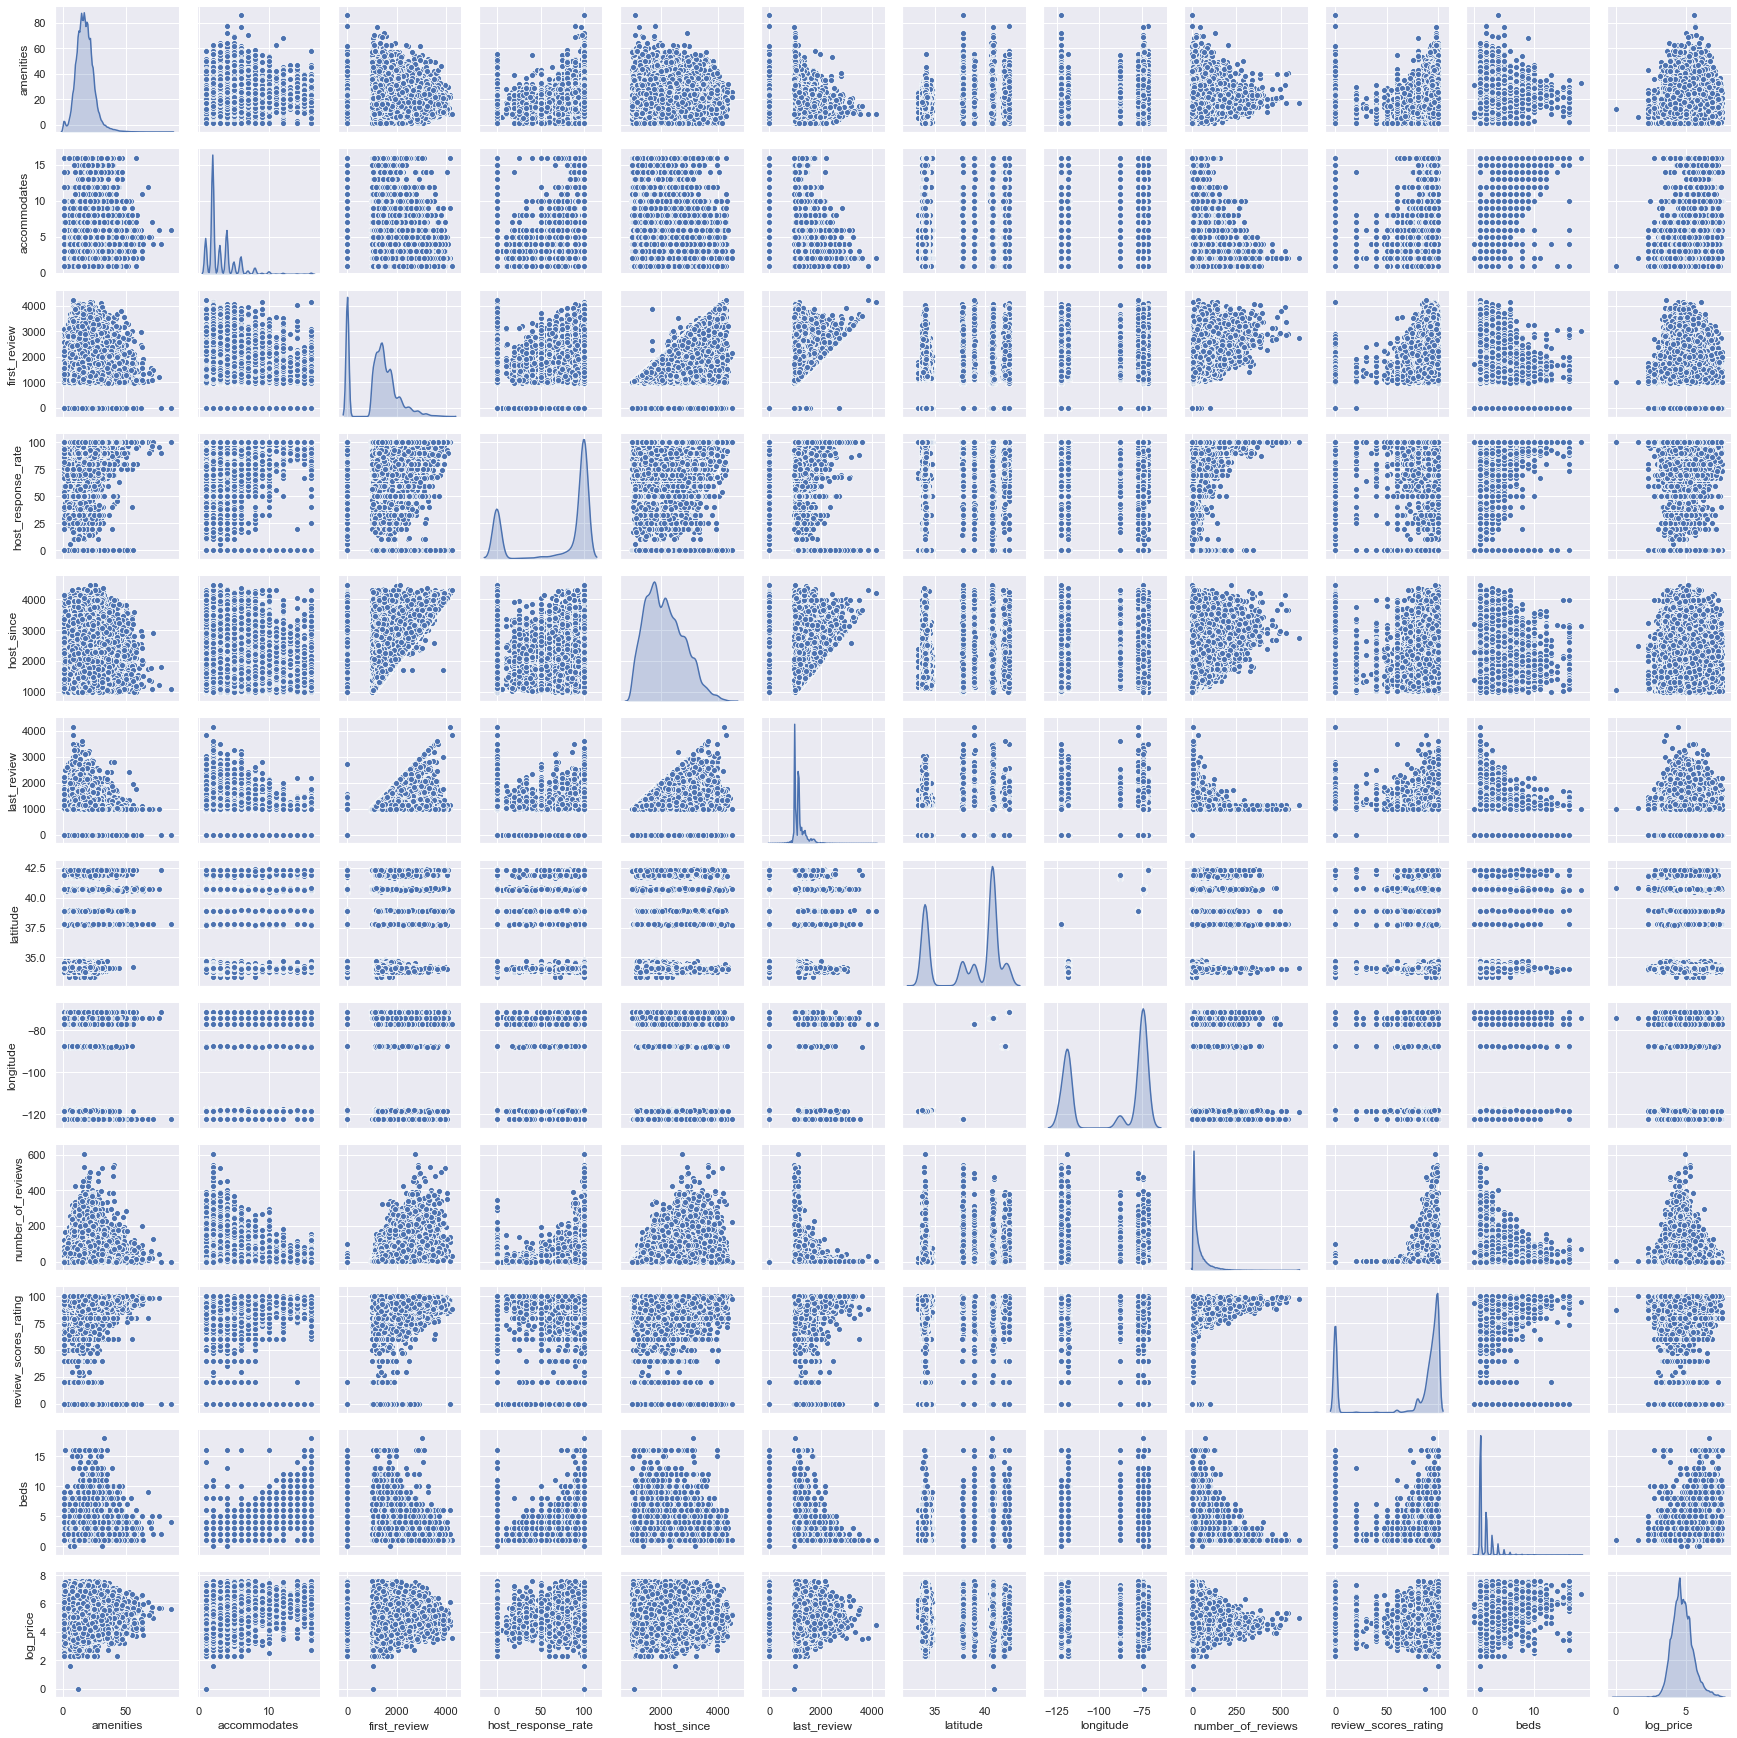

In [45]:
sns.set()
columns = ['amenities','accommodates','first_review','host_response_rate','host_since','last_review','latitude','longitude','number_of_reviews','review_scores_rating','beds']
df_pp = X[columns]
df_pp["log_price"] = y
sns.pairplot(df_pp,size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

Our dataset has now 688 columns and is almost ready to be used. In order to train and evaluate different machine learning models, this dataset must also be split into a training and test datasets. Here, I'm going to use a 80/20 split.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline model

<p style="text-align: justify">The baseline model for a regression problem is to simply predict without the additional information brought by the features, that is, using only the target variable. The best predictor, which minimizes the RMSE, is the average of the distribution of the target variable, and thus will be used as baseline of comparison with other models.</p>
<p style="text-align: justify">In fact, if we use the R² as the evaluation metric, this baseline is already incorporated in the formula, so all the performances will be measured relative to this baseline.</p>

In [14]:
y.mean()

4.78289006490994

For this problem, the baseline model is to always predict 4.78 as the log of the price.

## First model: Linear Regression

In [15]:
import multiprocessing as mp
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import cross_validate
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

Let's first try a simple linear regression model without droping any features. Due to the increased number of columns, we will probably overfit the data.

In [16]:
lrm = LR()
results = cross_validate(lrm, X_train, y_train, cv=5, return_train_score = True)
print("R²: " + str(results["train_score"].mean()))
print("OSR²: " + str(results["test_score"].mean()))

R²: 0.6800847075976497
OSR²: 0.6687950671729456


We can see a difference between the R² (training set) and the Out-of-Sample R² (test set) due to overfitting, although I was expecting a larger difference. This gap can be reduced by removing some irrelevant features from the dataset. In order to select the features, I'll analyze the p-values of each feature (probability that the true coefficient is zero) and remove the ones with p-value > 5%

In [17]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
relevant_columns = est2.pvalues.index[est2.pvalues <= 0.05].drop("const")
relevant_columns

Index(['amenities', 'accommodates', 'bathrooms', 'cleaning_fee',
       'first_review', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review',
       ...
       'neighbourhood_Westchester/Playa Del Rey',
       'neighbourhood_Western Addition/NOPA', 'neighbourhood_Westlake',
       'neighbourhood_Westside', 'neighbourhood_Westwood',
       'neighbourhood_Wicker Park', 'neighbourhood_Williamsburg',
       'neighbourhood_Willowbrook', 'neighbourhood_Woodley Park',
       'neighbourhood_Wrigleyville'],
      dtype='object', length=284)

In [18]:
# iterate the same process until no feature is removed anymore
num_columns_old = 1
num_columns_new = 0
while num_columns_old != num_columns_new:
    num_columns_old = len(relevant_columns)
    X_train_lr = X_train[relevant_columns]
    X2 = sm.add_constant(X_train_lr)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    relevant_columns = est2.pvalues.index[est2.pvalues <= 0.05].drop("const")
    num_columns_new = len(relevant_columns)

In [19]:
relevant_columns

Index(['amenities', 'accommodates', 'bathrooms', 'cleaning_fee',
       'first_review', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review',
       ...
       'neighbourhood_Westchester/Playa Del Rey',
       'neighbourhood_Western Addition/NOPA', 'neighbourhood_Westlake',
       'neighbourhood_Westside', 'neighbourhood_Westwood',
       'neighbourhood_Wicker Park', 'neighbourhood_Williamsburg',
       'neighbourhood_Willowbrook', 'neighbourhood_Woodley Park',
       'neighbourhood_Wrigleyville'],
      dtype='object', length=282)

We started with 688 features and we ended with 282. Let's now evaluate again the performance of the model with the subset of features.

In [20]:
results = cross_validate(lrm, X_train[relevant_columns], y_train, cv=5, return_train_score = True)
print("R²: " + str(results["train_score"].mean()))
print("OSR²: " + str(results["test_score"].mean()))

R²: 0.6757257753871935
OSR²: 0.6701256188899569


Indeed, the gap between the training and test scores decreased a little. That's because those irrelevant features were probably adding noise to the predictions.

Now that we selected the relevant features for the model, we can compute the final score with the test set:

In [36]:
lrm.fit(X_train[relevant_columns], y_train)
lrm_score = lrm.score(X_test[relevant_columns], y_test)
lrm_score

0.6536678845224256

## Second model: Decision Tree

The linear regression model has very strong assumptions about the data, which usually don't always hold. Decision Trees, however, are non-parametric models with more flexibility to fit the data, although they are more prone to overfitting.

In order to reduce overfitting, I'm going to train a large decision tree (until we have 1 sample per leaf node) and then I'm going to prune the tree with the complexity parameter cp. This parameter will be chosen through 5-fold cross-validation.

In [22]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import plot_tree
from tqdm import tqdm

In [23]:
train_scores = []
val_scores = []
cps = []
for cp in tqdm([0,0.00005,0.0001,0.0005,0.001]):
    cps.append(cp)
    dtr = DTR(ccp_alpha=cp)
    results = cross_validate(dtr, X_train[relevant_columns], y_train, cv=5, return_train_score = True)
    train_scores.append(results["train_score"].mean())
    val_scores.append(results["test_score"].mean())

100%|██████████| 5/5 [03:55<00:00, 47.15s/it]


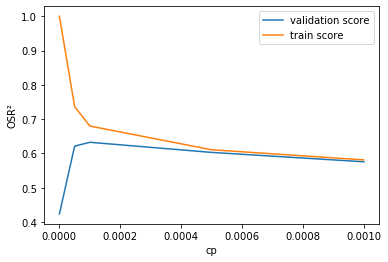

In [24]:
ax=plt.plot(cps, val_scores)
ax=plt.plot(cps, train_scores)
ax=plt.legend(["validation score", "train score"])
ax=plt.xlabel("cp")
ax=plt.ylabel("OSR²")

From the plot above, we can see that cp=0.0001 gives the best OSR² score. Let's now train the Decision Tree algorithm with that cp value.

In [25]:
dtr = DTR(ccp_alpha=0.0001)
dtr.fit(X_train[relevant_columns], y_train)

DecisionTreeRegressor(ccp_alpha=0.0001, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [26]:
ft_importance = pd.DataFrame({"feature": relevant_columns, "importance": dtr.feature_importances_}).sort_values("importance", ascending=False).query("importance > 0")
print(ft_importance.shape[0])
ft_importance.head(6)

31


,feature,importance
37,room_type_Private room,0.423014
14,bedrooms,0.173099
38,room_type_Shared room,0.093567
11,longitude,0.090133
2,bathrooms,0.070387
10,latitude,0.055817


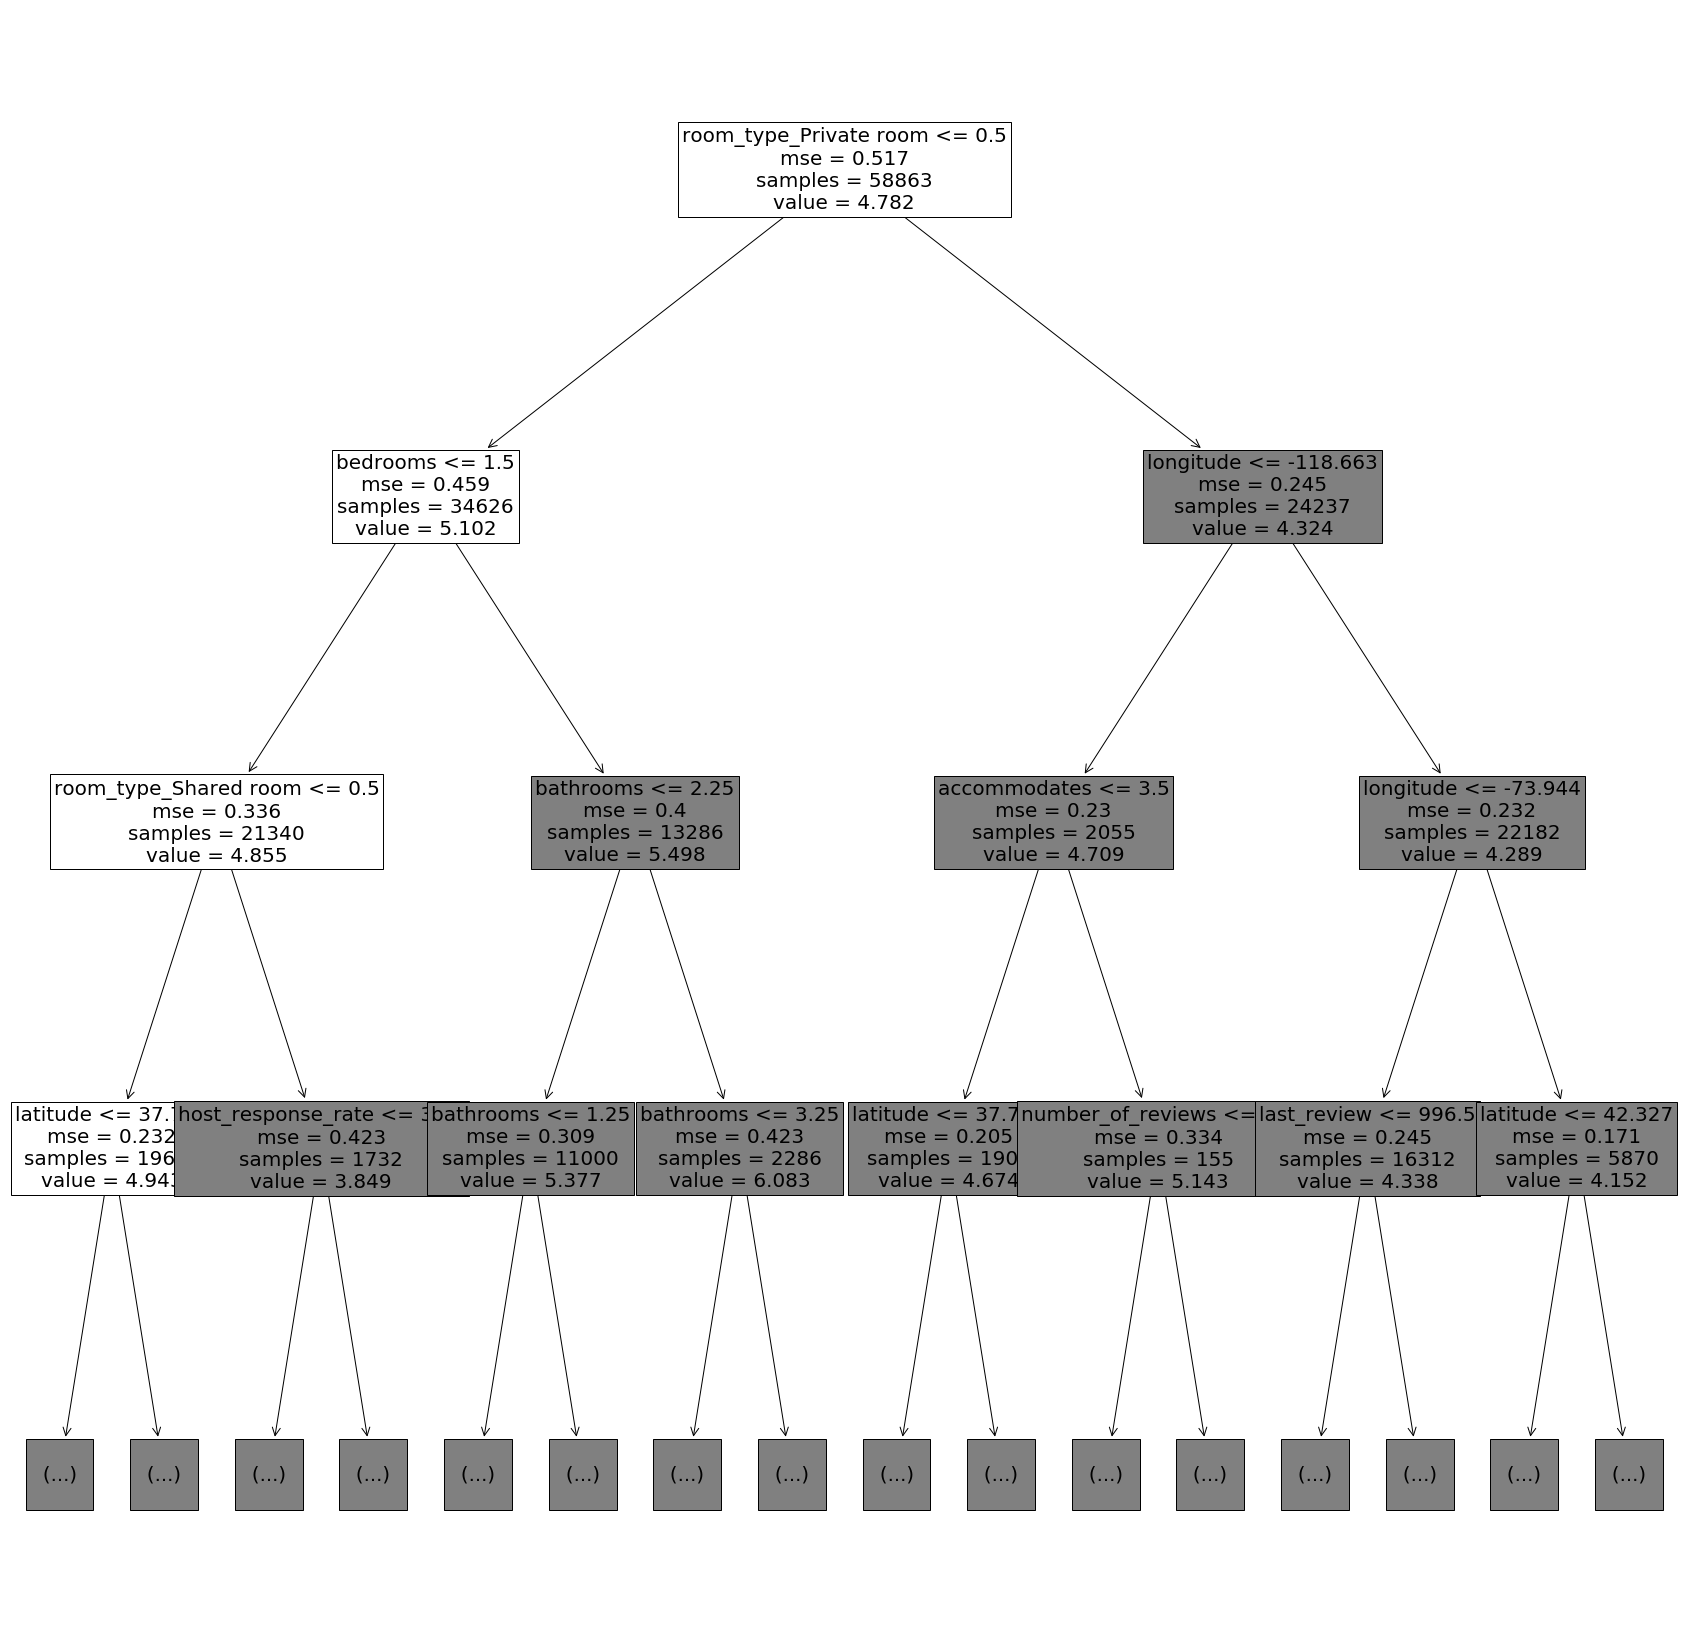

In [27]:
plt.figure(figsize=(30,30))
ax = plot_tree(dtr, feature_names = relevant_columns, fontsize=20, max_depth=3)

The Decision Tree regressor used only 32 of the 282 features available. The room type is the strongest predictor of the price, followed by the number of bedrooms, location (longitude/latitude) and number of bathrooms. This makes a lot of sense. Let's now see the final score on the test set:

In [35]:
dtr_score = dtr.score(X_test[relevant_columns], y_test)
dtr_score

0.6165181174356805

## Third model: Random Forest

Although the Decision Tree is more flexible than Linear Regression, it overfits the data more often. Even if we prune the tree, the greedy decisions we make in the beginning of the tree may not be the global optimum. One way to improve that is by training multiple weak trees with a random sample of the features and then combine the results. Each tree will be trained in a bootstrapped dataset from the original training set. This method is called Random Forest.

I'll fix the number of trees at 150 and I will fine tune the % of features used at each split. One of the advantages of Random Forest is that, as we use bootstrapped datasets, we can estimate the error of each row using trees that weren't trained with that row. This is called out-of-bag score, and I'll be using that instead of cross-validation to evaluate the parameters.

In [29]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [30]:
params = []
oob_scores = []
for i in tqdm(range(5)):
    max_ft = 0.4 + i/20
    params.append(max_ft)
    rfr = RFR(oob_score = True, max_features = max_ft)
    rfr.fit(X_train[relevant_columns], y_train)
    oob_scores.append(rfr.oob_score_)

100%|██████████| 5/5 [07:02<00:00, 84.41s/it]


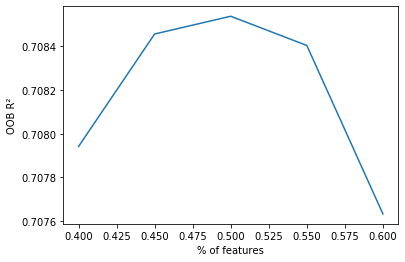

In [31]:
ax=plt.plot(params, oob_scores)
ax=plt.xlabel("% of features")
ax=plt.ylabel("OOB R²")

It seems that 45% of features gives us the best oob score. We can also see the feature importances, as we did for the Decision Tree Regressor.

In [37]:
rfr = RFR(max_features = 0.5)
rfr.fit(X_train[relevant_columns], y_train)
ft_importance = pd.DataFrame({"feature": relevant_columns, "importance": rfr.feature_importances_}).sort_values("importance", ascending=False).query("importance > 0")
print(ft_importance.shape[0])
ft_importance.head(6)

281


,feature,importance
37,room_type_Private room,0.199795
14,bedrooms,0.130747
11,longitude,0.098418
1,accommodates,0.086509
10,latitude,0.083718
38,room_type_Shared room,0.056083


The top features here are almost the same as before, but we now have *accomodates* in the list and we don't have *bathrooms* anymore. Let's see the final score on the test set:

In [38]:
rfr_score = rfr.score(X_test[relevant_columns], y_test)
rfr_score

0.6982681254892729

## Conclusion

A summary of the results obtained by each model can be found here:

In [39]:
print("Linear Regression: " + str(lrm_score))
print("Decision Tree: " + str(dtr_score))
print("Random Forest: " + str(rfr_score))

Linear Regression: 0.6536678845224256
Decision Tree: 0.6165181174356805
Random Forest: 0.6982681254892729


For this task, the linear regression did a great job and outperformed the decision tree. As said before, the Decision Tree takes greedy decisions on the splits, which are not necessarily the global optimal decisions. On top of that, they easily overfit the data, as small changes in the dataset may completely change the choice of splits. That's why usually Random Forests perform better, as it is more difficult to have high variance over an aggregation of multiple trees.

For this problem of predicting prices, indeed the Random Forest method obtained the best score, an OOSR² of 0.698. This means that around 70% of the original variance in the price is explained by the model, which is a very good result. By using this model, Airbnb could make targeted price recommendations to hosts in order to maximize revenue both for Airbnb and for the host. At the same time, users can use this model to check if the property is overvalued or undervalued with respect to the market.